# Boro Player Predictions - Current Market Value

## 0. Setup

In [15]:
## standard library
import os
import re

In [3]:
## data wrangling
import numpy as np
import pandas as pd

In [4]:
## visualisation
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

import seaborn as sns
sns.set()

In [5]:
## project src

## 1. Problem Definition

The aim of this project is to see if we can use data on players at Middlesbrough Football Club to make preditions about the player's and the team's current and future performance.

We have player data from Transfermarkt, ESPN, WhoScored and Fly Me To The Moon (fanzine).

"Performance" could be measured in many different ways: Results on the pitch, market value, fan popularity, churn, ...

## 2. Data Understanding

The first part of the data we'll look at is some general information on players, including their market value, as taken from Transfermarkt

In [95]:
dir_tmk_cnt = "../data/raw/tmk/tmk_cnt/"
data_list = []
for file in os.listdir(dir_tmk_cnt):
    filepath = os.path.join(dir_tmk_cnt, file)
    print(filepath)
    tmp = pd.read_csv(filepath, encoding='latin-1', header=0, 
                      names=["Shirt number", "Position", "Name", "Date of birth", "Nationality",
                            "Height", "Foot", "Joined", "Signed from", "Contract expires",
                            "Market value"])
    tmp["Season"] = file.split(".")[0].split("_")[-1]
    data_list.append(tmp)

tmk_df = pd.concat(data_list, axis=0, sort=False, ignore_index=True)

tmk_df["Name"].fillna(method="bfill", inplace=True)

tmk_df["Position"] = tmk_df.Name.shift(-1)
tmk_df.loc[tmk_df.Position == tmk_df.Name, "Position"] = tmk_df.Name.shift(-2)

tmk_df.drop(axis=1, columns=["Nationality", "Signed from"], inplace=True)

tmk_df.dropna(subset=["Market value"], inplace=True)

tmk_df = tmk_df.replace('-', np.nan)

tmk_df["Shirt number"] = pd.to_numeric(tmk_df["Shirt number"], downcast='integer')

tmk_df["Position group"] = None
tmk_df.loc[(tmk_df.Position.str.upper().str.contains("KEEPER"))
        | (tmk_df.Position.str.upper().str.contains("GOAL")), 
       "Position group"] = "G"
tmk_df.loc[(tmk_df.Position.str.upper().str.contains("BACK"))
        | (tmk_df.Position.str.upper().str.contains("DEF")), 
       "Position group"] = "D"
tmk_df.loc[(tmk_df.Position.str.upper().str.contains("MID"))
        | (tmk_df.Position.str.upper().str.contains("MIT"))
        | (tmk_df.Position.str.upper().str.contains("WING")), 
       "Position group"] = "M"
tmk_df.loc[(tmk_df.Position.str.upper().str.contains("STRIKER"))
        | (tmk_df.Position.str.upper().str.contains("FORW")), 
       "Position group"] = "F"

tmk_df["Age"] = tmk_df["Date of birth"].str.extract(r".*([0-9]{2})", expand=False).astype("int")

tmk_df["Date of birth"] = pd.to_datetime(
    tmk_df["Date of birth"].str.extract(r"(.*) \([0-9]{2}\)", expand=False), 
    format="%b %d, %Y")

tmk_df["Joined"] = pd.to_datetime(tmk_df.Joined, format="%b %d, %Y")

tmk_df["Contract expires"] = pd.to_datetime(tmk_df["Contract expires"], format="%d.%m.%Y")

tmk_df["Height"] = (tmk_df["Height"] \
                          .str.strip() \
                          .str.replace(' ', '') \
                          .str.replace(',', '') \
                          .str.replace('m', '') \
                          .replace({'-':np.nan, '':np.nan}) \
                          .astype(float))

tmk_df["Market value"] = (tmk_df["Market value"] \
                          .str.strip() \
                          .replace({'-':np.nan}) \
                          .replace(r'[£km]', '', regex=True) \
                          .astype(float) * \
            tmk_df["Market value"].str.extract(r'[\d\.]+([km]+)', expand=False)
                .fillna(1)
                .replace(['k','m'], [10**3, 10**6]).astype(int) / 10**6)

tmk_df.info()

../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_0910.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1011.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1112.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1213.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1314.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1415.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1516.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1617.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1718.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1819.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1920.csv
<class 'pandas.core.frame.DataFrame'>
Int64Index: 364 entries, 0 to 777
Data columns (total 12 columns):
Shirt number        333 non-null float64
Position            364 non-null object
Name                364 non-null object
Date of birth       364 non-null datetime64[ns]
Height              354 non-null float64
Foot                322 non-null object
Joined              351 non-null datetime64[ns]
Contract expires    169 non-null datetime64[ns]
Market val

In [109]:
tmk_df.sample(10, random_state=42)

,Shirt number,Position,Name,Date of birth,Height,Foot,Joined,Contract expires,Market value,Season,Position group,Age
386,9.0,Centre Forward,Danny Graham,1985-08-12,183.0,right,2014-01-31,NaT,3.000,1314,F,27
66,28.0,Right Wing,Jonathan Franks,1990-04-08,174.0,both,2008-07-01,NaT,0.075,0910,M,19
30,23.0,Left-Back,Jonathan Grounds,1988-02-02,185.0,left,2007-07-01,NaT,0.300,0910,D,21
738,33.0,Left-Back,Hayden Coulson,1998-06-17,172.0,left,2019-07-01,2023-06-30,1.620,1920,D,21
114,12.0,Centre Back,Andrew Davies,1984-12-17,190.0,right,2011-03-01,NaT,0.750,1011,D,25
366,18.0,Central Midfield,Dean Whitehead,1982-01-21,183.0,right,2013-07-01,NaT,1.880,1314,M,31
152,17.0,Right Midfield,Barry Robson,1978-11-07,180.0,left,2010-01-01,NaT,1.880,1011,M,31
238,30.0,Centre Forward,Lukas Jutkiewicz,1989-03-28,185.0,left,2012-01-01,NaT,0.750,1112,F,22
304,5.0,Attacking Midfield,Merouane Zemmama,1983-10-07,171.0,both,2011-01-01,NaT,0.375,1213,M,28
252,32.0,Keeper,Jayson Leutwiler,1989-04-25,192.0,right,2012-08-01,NaT,0.038,1213,G,23


In [97]:
tmk_df.describe(include="all")

,Shirt number,Position,Name,Date of birth,Height,Foot,Joined,Contract expires,Market value,Season,Position group,Age
count,333.000000,364,364,364,354.000000,322,351,169,330.000000,364,364,364.000000
unique,NaN,19,172,169,NaN,3,126,12,NaN,11,4,NaN
top,NaN,Centre Back,Ben Gibson,1993-01-15 00:00:00,NaN,right,2010-07-01 00:00:00,2020-06-30 00:00:00,NaN,0910,M,NaN
freq,NaN,53,9,9,NaN,199,31,28,NaN,47,134,NaN
first,NaN,NaN,NaN,1973-08-27 00:00:00,NaN,NaN,2000-07-01 00:00:00,2016-05-31 00:00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2000-08-09 00:00:00,NaN,NaN,2020-01-31 00:00:00,2023-06-30 00:00:00,NaN,NaN,NaN,NaN
mean,18.054054,NaN,NaN,NaN,183.262712,NaN,NaN,NaN,1.696327,NaN,NaN,24.826923
std,11.018471,NaN,NaN,NaN,6.034501,NaN,NaN,NaN,1.776398,NaN,NaN,4.696900
min,1.000000,NaN,NaN,NaN,167.000000,NaN,NaN,NaN,0.038000,NaN,NaN,16.000000
25%,8.000000,NaN,NaN,NaN,179.000000,NaN,NaN,NaN,0.375000,NaN,NaN,21.000000


In [121]:
tmk_df.count() / tmk_df.shape[0]

Shirt number        0.914835
Position            1.000000
Name                1.000000
Date of birth       1.000000
Height              0.972527
Foot                0.884615
Joined              0.964286
Contract expires    0.464286
Market value        0.906593
Season              1.000000
Position group      1.000000
Age                 1.000000
dtype: float64

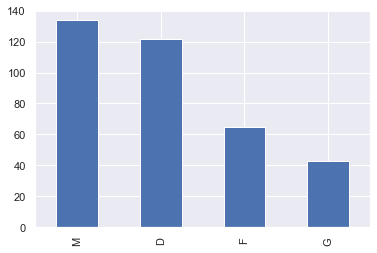

In [99]:
tmk_df["Position group"].value_counts().plot(kind='bar')

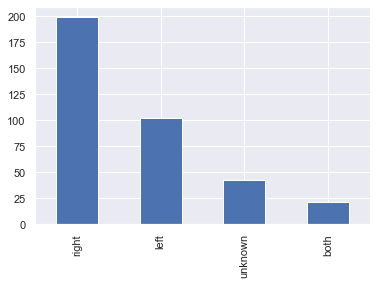

In [101]:
tmk_df.Foot.fillna("unknown").value_counts().plot(kind='bar')

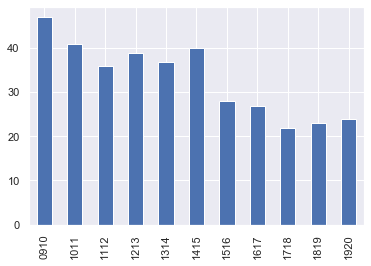

In [103]:
tmk_df.Season.value_counts().sort_index().plot(kind='bar')

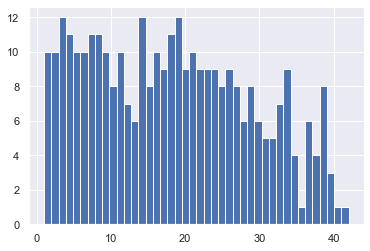

In [12]:
tmk_df["Shirt number"].hist(bins=42)

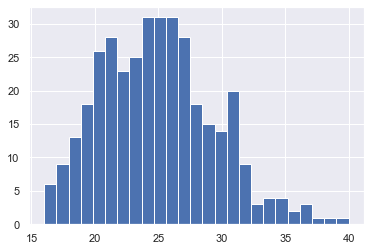

In [38]:
tmk_df["Age"].hist(bins=25)

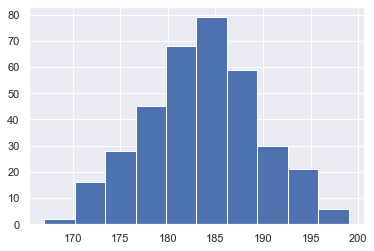

In [104]:
tmk_df["Height"].hist()

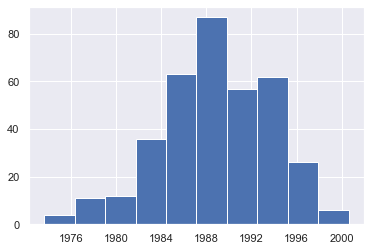

In [106]:
tmk_df["Date of birth"].hist()

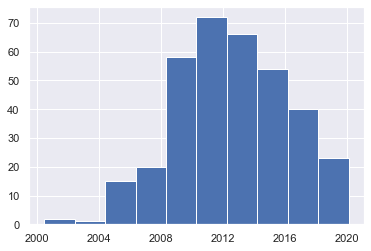

In [107]:
tmk_df["Joined"].hist()

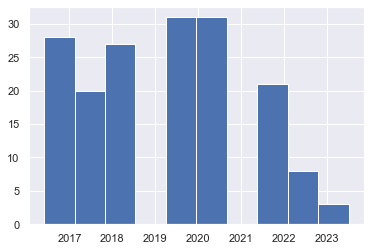

In [108]:
tmk_df["Contract expires"].hist()

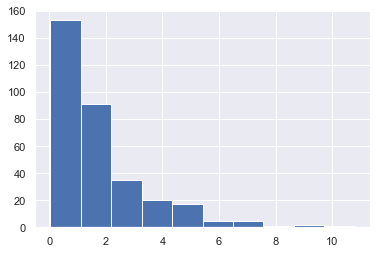

In [105]:
tmk_df["Market value"].hist()

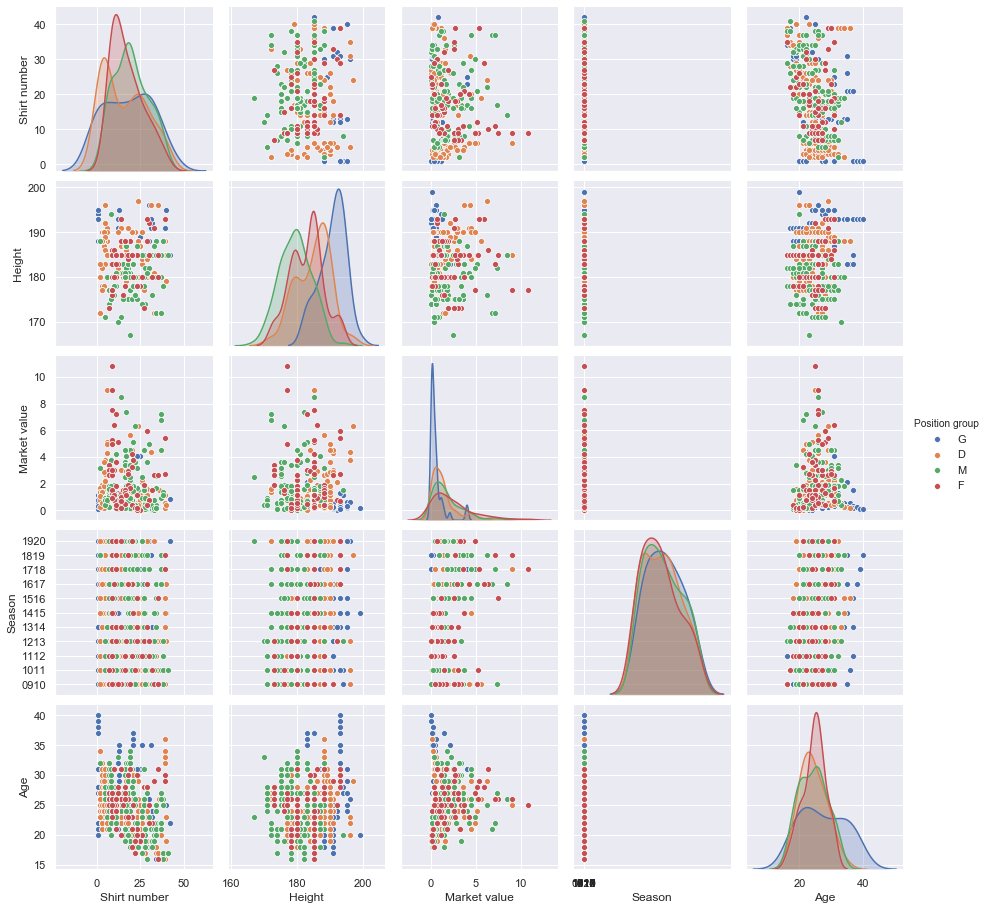

In [124]:
sns.pairplot(tmk_df, hue="Position group")

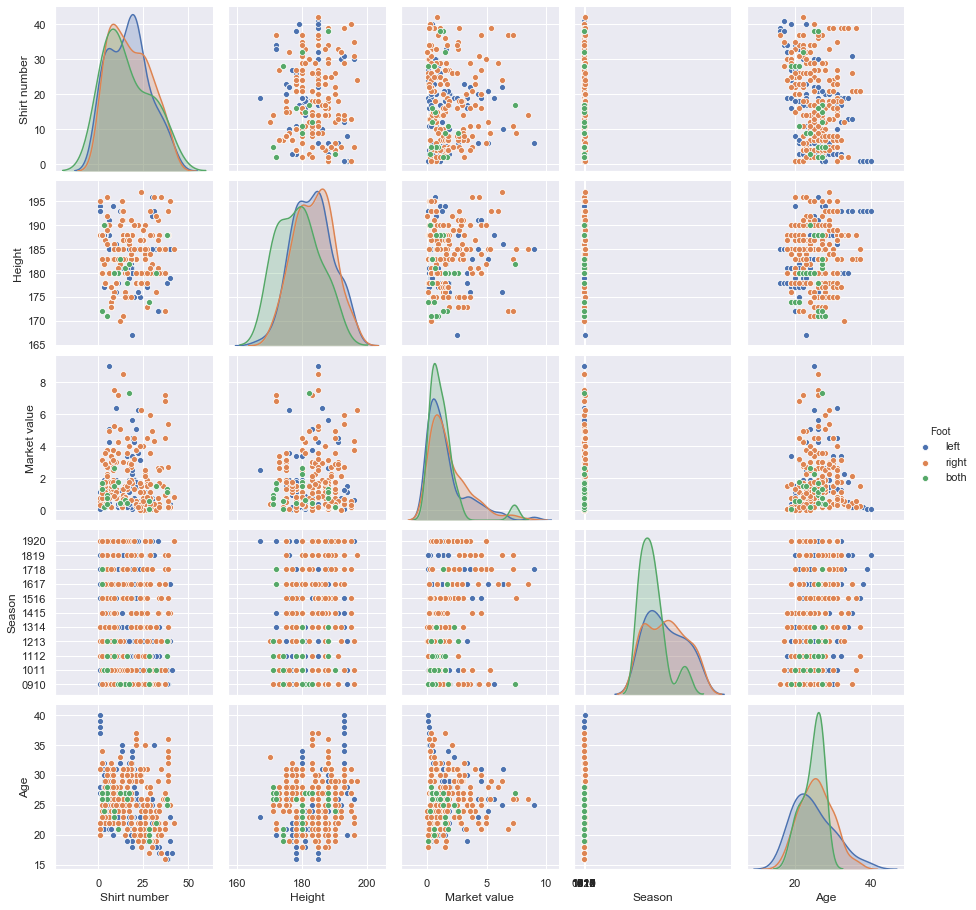

In [125]:
sns.pairplot(tmk_df, hue="Foot")

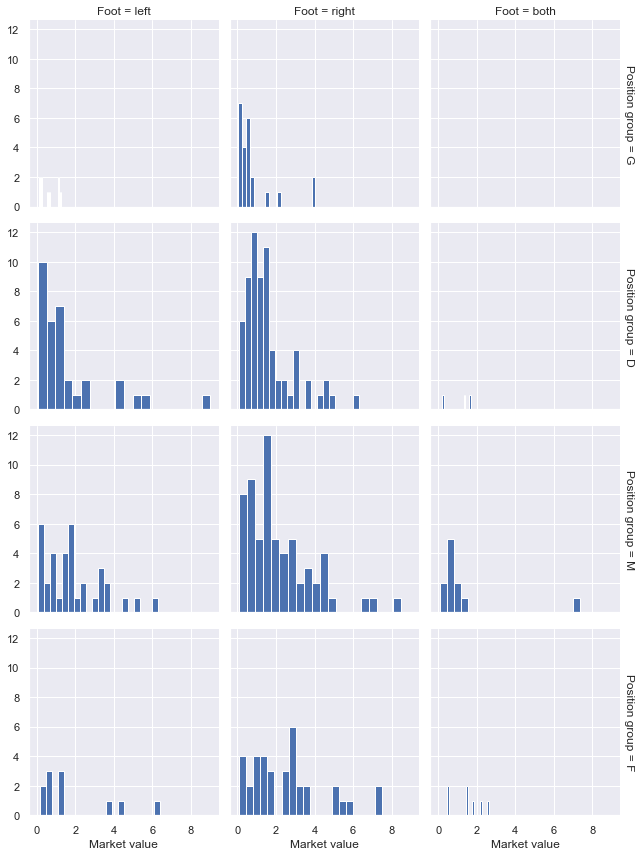

In [123]:
grid = sns.FacetGrid(tmk_df, row="Position group", col="Foot", margin_titles=True)
grid.map(plt.hist, "Market value", bins=20)

## 3. Data Preperation

In [1]:
# Feature Engineering
# Years in team
# Age when joined
# One-hot encode categorical variables (Position group and Foot)
# Missing values - remove or impute?
# Outliers
# Feature scaling
# Feature selection?

## 4. Modelling

In [1]:
# Test/train split
# Model selection - LinearRegression, Lasso, ElasticNet, RidgeRegression, SVR(kernel="linear")
# https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
# Learning curves 
# Validation (Grid Search)
# Pipeline

## 5. Evaluation

In [ ]:
# MSE, RMSE
# MAE
# R squared
# https://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/


## 6. Deployment

In [ ]:
# Fill missing values
# Any conclusions on predictions